In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys
import pickle

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from CosineTuning import *

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis

min_nblocks    = 2
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)

files          = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

In [ ]:
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings


def search_regularization(reg_opts, x_train, y_train):
    
    tuned_params = {'alpha' : reg_opts}
    clf          = GridSearchCV(Ridge(), tuned_params).fit(x_train, y_train)
    
    return clf.best_estimator_


def train_decoders(train_x, train_y, test_x, test_y, cfg):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        decoder      = search_regularization(cfg['reg_opts'], train_x, train_y)
        score        = decoder.score(test_x, test_y)
    
    return decoder, score



def processSingleSession(file, cfg):
    
    n_restarts   = 10
    session_dict = dict()
    fields       = ['TX', 'cursorPos', 'targetPos']
    
    # First calculate encoding and decoding weights independently for each session:
    session = DataStruct(file, causal_filter = cfg['sigma'], alignScreens = True)
    blocks  = block_constraints[file]

    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = cfg['train_size'], 
                               task = cfg['task'], blocks = blocks, returnFlattened = True) 
    session_dict['decoder_means'] = session_dat['test_TX'][-1].mean(axis = 0)
    
    train_y = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y  = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)

    # ===== train decoders ======
    scores = dict()
    for dim in cfg['FA_dims']:
        fas      = list()
        logprobs = list()
        for i in range(n_restarts):
            fa = FactorAnalysis(n_components=dim, random_state=i).fit(train_x)
            log_p = fa.score(train_x)
            fas.append(fa)
            logprobs.append(log_p)

        fa = fas[np.argmax(logprobs)]
        train_latent = fa.transform(train_x)
        test_latent  = fa.transform(test_x)
        
        _,    score = train_decoders(train_latent, train_y, test_latent, test_y, cfg)
        scores[dim] = score
    
    return scores

In [5]:
# general settings:
np.random.seed(42)
cfg = dict()

cfg['task']         = None
cfg['train_size']   = 0.5
cfg['sigma']        = 2
cfg['reg_opts']     = [1e1, 1e3, 1e5, 1e7, 1e9]
cfg['FA_dims']      = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 192]

# --------------------------------------------------
#dict_list = list()
#for file in files:
#    dict_list = processSingleSession(file, cfg) 
#    print(file)

dict_list    = Parallel(n_jobs=10, verbose = 11)(delayed(processSingleSession)(file, cfg) for file in files)
session_dict = dict()

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 78.1min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed: 88.2min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed: 125.2min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed: 125.7min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 148.7min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed: 154.4min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed: 174.7min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed: 176.0min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed: 199.6min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed: 209.0min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 216.5min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 224.6min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed: 229.5min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed: 241.2min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed: 246.9min
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed: 265

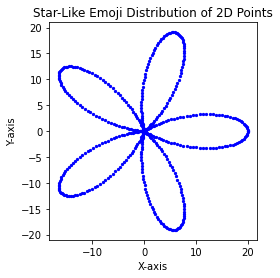

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def makeStarEmojiPoints(n_points):
    '''Returns a set of points forming a star-like emoji pattern.'''
    
    t = np.linspace(0, 2*np.pi, n_points)
    
    x = 10 * np.cos(t) * (1 + np.cos(5*t))
    y = 10 * np.sin(t) * (1 + np.cos(5*t))
    
    return x, y

# Number of points
n_points = 500

# Generate star-like emoji points
x, y = makeStarEmojiPoints(n_points)

# Plot the points
plt.scatter(x, y, s=5, color='blue')
plt.title('Star-Like Emoji Distribution of 2D Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
plt.show()

In [12]:
normalized_scores = np.zeros(((len(uniqueFiles)), len(cfg["FA_dims"])))
for i, data in enumerate(dict_list):
    scores = np.asarray([data[dim] for dim in cfg['FA_dims']])
    normalized_scores[i, :] = scores / data[192]

Text(0, 0.5, 'Normalized R2')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

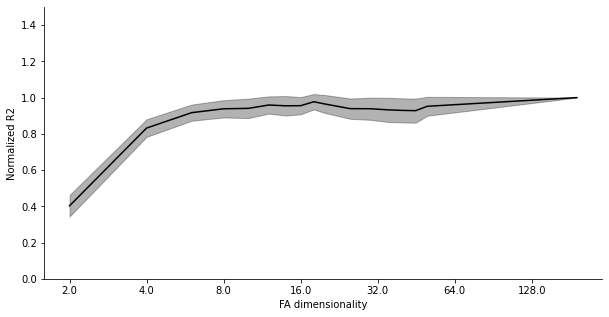

In [61]:
figSize(5, 10)
from matplotlib.ticker import ScalarFormatter

#_ = plt.plot(cfg['FA_dims'], normalized_scores.T, color = 'k', alpha = 0.3)
plotsd(normalized_scores, time_bins= cfg['FA_dims'], color = 'k', alpha = 0.3, toggleSE = True)
plt.ylim([0, 1.5])

ax = plt.gca()
ax.set_xscale('log', base=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.xlabel("FA dimensionality")
plt.ylabel('Normalized R2')